# Popped

The pairwise ordering probability (POP), also often (and unfortunately) known as AUC, AUROC or AUC-ROC is a useful measure of how well a binary classifier separates its two classes. This notebook describes variations on this basic idea, specifically how it can be extended to multiple classes, and how it can be modified to be differentiable.

# Extensions

Note, all of the implementations in this notebook assume that ties between scores (and labels too, in the continuous ca) will not occur.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

## Ordinal Labels

Retaining notation from the previous notebook, the only difference between binary classification and orginal regression is in the label. This now becomes $y \in \{0, 1, \dots, K-1\}$, with $K \ge 2$. Any set of $K$ ordered values can be mapped to these.

### Sequence Ordering Probability

In the previous notebook, the motivation for the pairwise ordering probability was that it quantified how well a model could separate two classes, without dependence on the prevalence of those classes or any threshold value. The metric was defined using the following procedure:
* Draw a random example from each of the two classes.
* Compute the model score for each one.
* The POP is the probability that the $1$-class example has a larger score than the $0$-class example.

However, we can restate this in such as a way that it does not depend on the number of classes:
* Draw a random example from each of the $K$ classes.
* Compute the model score for each one.
* Sort them in increasing order of model score.
* The sequence ordering probability (SOP) is the probability that the examples are now in label order.

This is a generalization of POP, in the sense that it is exactly the same for $K=2$. It retains the useful fact that it is a function only of the model, with no dependence on the class prevalence.

However, it is of practical use only for small $K$. As the number of classes grows, it becomes harder and harder to put them all in order correctly, even with constant ability to separate any two adjacent classes.

Here's a cute little toy example. Suppose $s \sim \mathcal{N}(y, \sigma)$, with $\sigma = \frac{1}{2}$. For $K=2$, this looks like a pretty good classifier. We can compute the POP analytically as $\zeta = \Phi\left(\frac{1}{\sqrt{2} \: \sigma}\right) \approx 0.921$. However, as we increase $K$, every adjacent pair of classes incurs the same probability of being incorrectly ordered, so we can crudely approximate the overall probability of getting all the samples in order as $\zeta^{K-1}$. This is wrong, of course, because it ignores the fact that each adjacent pair is not independent of the others, but it matches simulation pretty well.

In [10]:
def is_ordered(x):
  return np.all(np.diff(x) > 0)

def sample(sd, K):
  return np.arange(0, K) + stats.norm.rvs(loc=0, scale=sd, size=K)

def test_ordering(sd, K, N):
  num_good = 0
  for _ in range(N):
    num_good += is_ordered(sample(sd, K))
  return num_good/N  

0.921


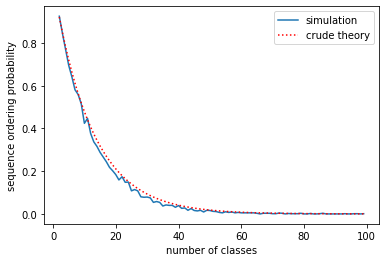

In [11]:
N = 1000
sd = 0.5

K_max = 100
K_range = np.arange(2, K_max)
p_range = np.zeros(K_max - 2)

for i, K in enumerate(K_range):
  p_range[i] = test_ordering(sd, K, N)

zeta = stats.norm.cdf(1, loc=0, scale=(2*sd**2)**0.5)
print(f'{zeta:.3f}')

fig, ax = plt.subplots()
ax.plot(K_range, p_range, label='simulation')
ax.plot(K_range, zeta**(K_range-1), ':r', label='crude theory')
ax.set_xlabel('number of classes')
ax.set_ylabel('sequence ordering probability')
ax.legend()
plt.show()

For pairwise class comparisons, this is a good binary classifier, and yet the probability of getting all the samples in the right order drops below $0.5$ by the time we reach $K=10$, and by $K=50$ it's basically always $0$. Things get worse if some pairwise comparisons are harder than others.

The problem with this measure is that it's all-or-nothing. Either we get all $K$ samples in the correct order and it's a success, or we get anything else and it's a failure. This neglects the fact that some orderings are better than others.

### Soft Sequence Ordering

In the previous section we used a hard outcome to evaluate our ordering procedure, with a 1 only when the examples are perfectly in line and 0 otherwise. We might instead try using some continuous value between 0 and 1 to quantify how well ordered they are. There are a number of possibilities here.

#### Correlation

We can quantify how well ordered the classes are by computing the correlation with a perfect ordering. This gives a value between -1 and 1, with 1 achieved when our model orders the examples perfectly. We can scale and shift this to give a score between 0 and 1. 

In [12]:
def ordering_correlation(scores):
  K = len(scores)
  return 0.5 + 0.5 * stats.spearmanr(np.arange(K), scores)[0]

#### Inversions

The number of inversions is a count of the number of index pairs $i,j$ for which $j > i, x_j < x_i$. This takes a value between 0 and $^KC_2$. Again, this can be scaled and shifted to give us a score between 0 and 1 for how well the model has ordered the examples.

In [13]:
def num_inversions(x):
  n = 0
  for i, xi in enumerate(x):
    for j, xj in enumerate(x[i+1:]):
      if xi > xj:
        n += 1
      elif xi == xj:
        n += 0.5
  return n

def ordering_inversions(scores):
  n = num_inversions(scores)
  K = len(scores)
  KC2 = K * (K - 1) / 2
  return 1 - (n / KC2)

#### Deletions

Finally, we can quantify ordering by counting the number of examples which must be deleted such that those remaining are in order. This takes a value between 0 and $K-1$, which we can rescale to give us another ordering score. 

In [14]:
def best_sequence(arr):
  memo = {}
  cnt = 0

  def partial(min, start):
    best = []
    if start >= len(arr):
      return best
    if (min, start) in memo:
      return memo[(min, start)]
    for i, x in enumerate(arr[start:]):
      if (min is None) or (x >= min):
        remx = partial(x, start+i+1)
        if (1 + len(remx)) > len(best):
          best = [x] + remx
    memo[(min, start)] = best
    return best

  return partial(None, 0)

def ordering_deletions(scores):
  K = len(scores)
  n = len(best_sequence(scores))
  return (n - 1) / (K - 1)

#### Comparison

These different methods for quantifying how well the model orders the examples are all generalizations of the binary POP, and are thus all equivalent for $K=2$. However, they lead to very different outcomes. We can test them on our toy model from before.

In [15]:
def test_ordering(sd, K, N, ordering_fn):
  sum = 0
  for _ in range(N):
    sum += ordering_fn(sample(sd, K))
  return sum/N

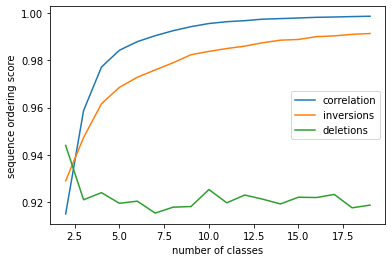

In [16]:
N = 1000
sd = 0.5

K_max = 20
K_range = np.arange(2, K_max, dtype=int)
order_cor = np.zeros(K_max-2)
order_inv = np.zeros(K_max-2)
order_del = np.zeros(K_max-2)

for i, K in enumerate(K_range):
  order_cor[i] = test_ordering(sd, K, N, ordering_correlation)
  order_inv[i] = test_ordering(sd, K, N, ordering_inversions)
  order_del[i] = test_ordering(sd, K, N, ordering_deletions)

fig, ax = plt.subplots()
ax.plot(K_range, order_cor, label='correlation')
ax.plot(K_range, order_inv, label='inversions')
ax.plot(K_range, order_del, label='deletions')
ax.set_xlabel('number of classes')
ax.set_ylabel('sequence ordering score')
ax.legend()
plt.show()

Sooo... they all do different things as the number of classes increases. It isn't really clear which of these is "right", and the choice of ordering score will depend on the application.

### Binary POP For Multiple Classes

There's a completely different way in which we can generalize binary POP to $K > 2$. We can stick with pairwise comparisons, and consider all possible pairs of classes. We can write this generalization as follows:
* Draw two samples from the full joint distribution, conditional on the class of the second being greater than the class of the first.
* Compute the model score for each one.
* The pairwise ordering probability is the probability that the second sample has the larger score.

We can write this as:

\begin{equation}
p(\hat{s} > \check{s} | \hat{y} > \check{y})
\end{equation}

Notation borrowed from previous notebook. $\check{}$ indicates quantities associated with the lower class and $\hat{}$ with the upper class.

For $K = 2$, the condition that the second sample class be greater than the first dictates that $\check{y} = 0$ and $\hat{y}=1$, and so sampling from the full joint distribution reduces to sampling features from each class conditional.

Very importantly, with $K>2$, POP is no longer independent of the class distribution. Rare classes will be sampled less, and so will have less effect on the value.

This generalization retains the simple, intuitive interpretation, that POP measures the models ability to correctly rank a random pair of examples.

We expand the POP thus:

\begin{align}
p(\hat{s} > \check{s} | \hat{y} > \check{y}) &= \sum_{i} \sum_{j} p(\hat{s} > \check{s} , \hat{y} = j, \check{y} = i | \hat{y} > \check{y}) \\
&= \sum_{i} \sum_{j > i} p(\hat{s} > \check{s} , \hat{y} = j, \check{y} = i) \\
&= \sum_{i} \sum_{j>i} p(\hat{s} > \check{s} | \hat{y} = j, \check{y} = i) \: p(\hat{y} = j) \: p(\check{y} = i)
\end{align}

Here we see that multi-class POP is also the average of the $\frac{K(K-1)}{2}$ different binary POPs between each pair of classes, weighted according to their base rate.

#### Implementation

In [26]:
def generate_multiclass_data(K, num_per_class=1000):
  def draw_class_samples(mn, num=1):
    return stats.t.rvs(3, loc=mn, scale=0.5, size=num)
  x_by_class = []
  y_by_class = []
  for k in range(K):
    x_by_class.append(draw_class_samples(k, num=num_per_class))
    y_by_class.append(k * np.ones((num_per_class), dtype=int))
  return np.concatenate(x_by_class), np.concatenate(y_by_class)

In [117]:
x, y = generate_multiclass_data(5, num_per_class=20)

We can compute multi-class POP simply by looping through every possible pair of samples, and counting the number which are correctly ordered. The complexity of this is quadratic in the number of samples in the data set.

In [172]:
def multiclass_pop_exhaustive(x, y):
  N = len(y)
  num = 0
  den = 0
  for i in range(N):
    for j in range(i):
      if y[i] == y[j]:
        continue
      den += 1
      if (x[i] < x[j]) == (y[i] < y[j]):
        num += 1
  return num / den

We can reduce the complexity to $\mathcal{O}(N \log N + KN)$ as follows:

*  First sort the samples by model score.
*  Then step through the list, keeping track of how many samples of each class have a score less than the current sample.
* We can use these running totals to enumerate the number of pairs which are incorrectly ordered.

In [150]:
def multiclass_pop_efficient(x, y):
  K = len(np.unique(y))
  N = len(y)

  idx = np.argsort(x)
  y_sort = y[idx]

  num_wrong = 0
  num_less_than = np.zeros((K))
  for n in range(N):
    for k in range(y_sort[n]+1, K):
      num_wrong += num_less_than[k]
    num_less_than[y_sort[n]] += 1

    # print(num_wrong, num_less_than)

  N_per_class = np.array([np.sum(y == k) for k in range(K)])
  num_pairs = N**2 - np.sum(N_per_class**2)
  
  # print(num_wrong, num_pairs)

  return 1.0 - num_wrong / (num_pairs / 2)

We can also get an estimate very simply by resampling pairs.

In [77]:
def multiclass_pop_montecarlo(x, y, num_samples=1000):
  N = len(y)
  num = 0
  den = 0
  for _ in range(num_samples):
    i = np.random.randint(N)
    j = np.random.randint(N)
    if y[i] == y[j]:
      continue
    den += 1
    if (x[i] < x[j]) == (y[i] < y[j]):
      num += 1
  return num / den

In [173]:
print(multiclass_pop_exhaustive(x, y))
print(multiclass_pop_efficient(x, y))
print(multiclass_pop_montecarlo(x, y))

0.92875
0.92875
0.9263420724094882


## Continuous Labels

SOP does not make any sense for continuous labels. We cannot draw one sample from each class, because there are no classes.

On the other hand, the formulation of multi-class POP for ordinal labels extends trivially to a continuous label. We just let $K \rightarrow \infty$. Nothing else needs modifying.

#### Implementation

In [192]:
def generate_continuous_data(num_samples=1000):
  def draw_samples(mn):
    return stats.t.rvs(3, loc=mn, scale=0.5)
  y = np.linspace(0, 5, num=num_samples)
  x = draw_samples(y)
  return x, y

In [193]:
x, y = generate_continuous_data(num_samples=30)

The exhaustive and bootstrap POP estimates that we developed for ordinal labels work just fine for continuous labels.

In [211]:
print(multiclass_pop_exhaustive(x, y))
print(multiclass_pop_montecarlo(x, y))

0.8942528735632184
0.8837448559670782


The "efficient" method can also be applied. If we could truly draw samples from the joint distribution, then there would be an uncountable number of classes, but since we're working with a finite data set, we can map the observed label values to integers.

In [212]:
print(multiclass_pop_efficient(x, np.arange(len(y))))

0.8942528735632184


However, this method is not efficient any more. Recall that the complexity was $\mathcal{O}(KN)$, but now $K=N$, so we're back to quadratic complexity.

We can do better. As before, sort the samples by score, and loop through them in order. As we go, we maintain a sorted list of labels, containing those with a score smaller than the current sample. We can use these to count the pairs which are incorrectly ordered.

This achieves $\mathcal{O}(N \log N)$ complexity, firstly to sort the scores, and then again because of an $\mathcal{O}(\log N)$ operation to insert the new label in the sorted list for each of the $N$ samples.

In [232]:
def continuous_pop_efficient(x, y):
  N = len(y)

  idx = np.argsort(x)
  y_sort = y[idx]

  num = 0
  den = 0
  below = []
  
  for n in range(N):
    # den += (N - 1)
    den += n

    # Current sample
    yy = y_sort[n]

    # Insert it into the below list, maintaining sort order.
    bel_idx = np.searchsorted(below, yy)
    below.insert(bel_idx, yy)

    # Count how many pairs are incorrectly below.
    num += bel_idx

    # print(num, den)

  return num / den

In [233]:
print(continuous_pop_efficient(x, y))

0.8942528735632184


# Differentiable Approximations